## Serve a model with TensorFlow Serving



In [1]:
import os
import zipfile
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from IPython.display import Image, display
import tempfile
import json
import requests

In [2]:
mnist= tf.keras.datasets.mnist

In [3]:
(x_train, y_train), (x_test, y_test)= mnist.load_data()

In [4]:
x_train= x_train/255.0
x_test= x_test/255.0

In [5]:
x_train= x_train.reshape(x_train.shape[0],28,28,1)
x_test= x_test.reshape(x_test.shape[0],28,28,1)

In [6]:
print('\n x_train.shape: {}, of {}'.format(x_train.shape, x_train.dtype))
print('\n x_test.shape: {}, of {}'.format(x_test.shape, x_test.dtype))


 x_train.shape: (60000, 28, 28, 1), of float64

 x_test.shape: (10000, 28, 28, 1), of float64


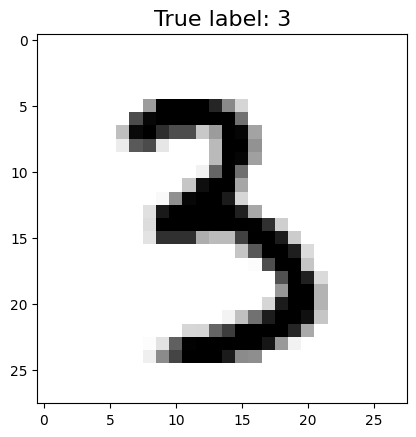

In [7]:
idx= 32
plt.imshow(x_test[idx].reshape(28,28), cmap=plt.cm.binary)
plt.title('True label: {}'.format(y_test[idx]), fontdict={'size':16})
plt.show()

In [8]:
model= tf.keras.Sequential([
    tf.keras.layers.Conv2D(input_shape=(28,28,1), filters=8, kernel_size=3,
                           strides=2, activation='relu', name='Conv1'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation= tf.nn.softmax, name='Softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 13, 13, 8)         80        
                                                                 
 flatten (Flatten)           (None, 1352)              0         
                                                                 
 Softmax (Dense)             (None, 10)                13530     
                                                                 
Total params: 13610 (53.16 KB)
Trainable params: 13610 (53.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

epochs=5

history= model.fit(x_train, y_train, epochs= epochs)

Epoch 1/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3647 - accuracy: 0.9001
Epoch 2/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1691 - accuracy: 0.9527
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1266 - accuracy: 0.9639
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1054 - accuracy: 0.9696
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0919 - accuracy: 0.9737


In [10]:
results_eval= model.evaluate(x_test, y_test, verbose=0)

for metric, value in zip(model.metrics_names, results_eval):
  print(metric + ':{:.3}'.format(value))

loss:0.0905
accuracy:0.973


In [11]:
MODEL_DIR= tempfile.gettempdir()
version=1
export_path= os.path.join(MODEL_DIR, str(version))

if os.path.isdir(export_path):
  !rm -r {export_path}

model.save(export_path, save_format="tf")
print('\n export path= {}'.format(export_path))
!ls -l {export_path}


 export path= /tmp/1
total 100
drwxr-xr-x 2 root root  4096 Dec 19 19:52 assets
-rw-r--r-- 1 root root    57 Dec 19 19:52 fingerprint.pb
-rw-r--r-- 1 root root  8613 Dec 19 19:52 keras_metadata.pb
-rw-r--r-- 1 root root 76219 Dec 19 19:52 saved_model.pb
drwxr-xr-x 2 root root  4096 Dec 19 19:52 variables


In [12]:
!wget 'http://storage.googleapis.com/tensorflow-serving-apt/pool/tensorflow-model-server-universal-2.8.0/t/tensorflow-model-server-universal/tensorflow-model-server-universal_2.8.0_all.deb'
!dpkg -i tensorflow-model-server-universal_2.8.0_all.deb

--2023-12-19 19:52:53--  http://storage.googleapis.com/tensorflow-serving-apt/pool/tensorflow-model-server-universal-2.8.0/t/tensorflow-model-server-universal/tensorflow-model-server-universal_2.8.0_all.deb
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.163.207, 142.251.167.207, 172.253.115.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.163.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 335421916 (320M) [application/x-debian-package]
Saving to: ‘tensorflow-model-server-universal_2.8.0_all.deb.2’

tensorflow-model-se 100%[===================>] 319.88M  72.8MB/s    in 4.8s    

2023-12-19 19:52:58 (66.5 MB/s) - ‘tensorflow-model-server-universal_2.8.0_all.deb.2’ saved [335421916/335421916]

(Reading database ... 121659 files and directories currently installed.)
Preparing to unpack tensorflow-model-server-universal_2.8.0_all.deb ...
Unpacking tensorflow-model-server-universal (2.8.0) over (2.8.0) ...
Sett

In [13]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [14]:
%%bash --bg
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=animal_classifier \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

In [15]:
!tail server.log

In [16]:
data= json.dumps({"signature_name":"serving_default","instances":x_test[0:3].tolist()})

In [17]:
headers= {"content-type":"application/json"}

In [18]:
json_response = requests.post('http://localhost:8501/v1/models/digits_model:predict', data=data, headers=headers)
print( json_response.json().keys())

ConnectionError: ignored

In [ ]:
predictions = json.loads(json_response.text)['predictions']